In [6]:
from diffusers import StableDiffusionPipeline, UNet2DConditionModel
import torch
import json
from utils.misc import *
import gc
import pandas as pd
import pandas as pd
from tqdm import tqdm
from utils.clip_eval import CLIPEvaluator
from transformers import AutoImageProcessor, AutoModel
from utils.layout_control import *
from transformers import CLIPTextModel
from matplotlib import pyplot as plt
import math


BACKGROUND = ['barn']
OBJ = ['cat', 'dog', 'chair', 'table', 'flower', 'wooden_pot']


def init_generative_model(args):
    if args.model_name == "sd-v1-5":
        model_id = "runwayml/stable-diffusion-v1-5"
        pipe = StableDiffusionPipeline.from_pretrained(model_id).to(args.device)
    elif args.model_name == 'textual_inversion':
        model_id = "runwayml/stable-diffusion-v1-5"
        if args.spatial_inversion:
            pipe = Layout_Control(model_id=model_id, device=args.device)
        else:
            pipe = StableDiffusionPipeline.from_pretrained(model_id).to(args.device)
    elif args.model_name == 'custom_diffusion' or args.model_name == 'dreambooth':
        model_id = "CompVis/stable-diffusion-v1-4"
        if args.spatial_inversion:
            pipe = Layout_Control(model_id=model_id, device=args.device)
        else:
            pipe = StableDiffusionPipeline.from_pretrained(model_id).to(args.device)
    return pipe


def load_trained_weights(args, pipe):
    """
    Load additional weights for the model
    params:
        model_name: str
        pipe: StableDiffusionPipeline
        unique_identifier_dir: str, where the additional unique identifier weights are saved
        file_names: list, file names for the concepts
    """
    if args.model_name == 'sd-v1-5':
        return pipe
    if args.model_name == 'textual_inversion':
        for file in args.file_names.split(','):
            pipe.load_textual_inversion(os.path.join(args.checkpoint, file))
    elif args.model_name == 'custom_diffusion' and args.spatial_inversion == False:
        pipe.unet.load_attn_procs(args.checkpoint, weight_name="pytorch_custom_diffusion_weights.bin")
        for file in args.file_names.split(','):
            pipe.load_textual_inversion(os.path.join(args.checkpoint, file))
    elif args.model_name == 'custom_diffusion' and args.spatial_inversion == True:
        pipe.load_attn_procs(args.checkpoint, weight_name="pytorch_custom_diffusion_weights.bin")
        for file in args.file_names.split(','):
            pipe.load_textual_inversion(os.path.join(args.checkpoint, file))
    elif args.model_name == 'dreambooth' and args.spatial_inversion == False:
        unet = UNet2DConditionModel.from_pretrained(os.path.join(args.checkpoint, 'unet')).to(pipe.device)
        pipe.unet = unet
        if os.path.exists(os.path.join(args.checkpoint, 'text_encoder')):
            text_encoder = CLIPTextModel.from_pretrained(os.path.join(args.checkpoint, 'text_encoder')).to(pipe.device)
            pipe.text_encoer = text_encoder
        for file in args.file_names.split(','):
            pipe.load_textual_inversion(os.path.join(args.checkpoint, file))
    elif args.model_name == 'dreambooth' and args.spatial_inversion == True:
        pipe.load_dreambooth_weights(args.checkpoint)
        for file in args.file_names.split(','):
            pipe.load_textual_inversion(os.path.join(args.checkpoint, file))
    else:
        raise ValueError(f'Unknown model name {args.model_name}')
    return pipe

## Generate image with spatial inversion

### Initialize the generative model

In [10]:
args = {
    "model_name": "custom_diffusion",  # textual_inversion, dreambooth, custom_diffusion
    "spatial_inversion": False,   # True or False
    "device": "cuda:0",
    "checkpoint": "./snapshot/compositional_custom_diffusion/cat", # path to the checkpoint
    "file_names": "<cute-cat>.bin" # <c1>.bin,<c2>.bin for 2 inverted concepts
}
args = Dict2Class(args)

pipe = init_generative_model(args)
pipe = load_trained_weights(args, pipe)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


### Generate with Spatial Inversion

In [7]:
input_dict = {'prompt': 'cat and backpack', 
                'edited_prompt': '<cute-cat> cat and backpack', 
                'identifier': '<cute-cat>; backpack', 
                'bboxes': [[[0.1, 0.2, 0.5, 0.8]], [[0.6, 0.2, 0.95, 0.8]]]}
im = pipe(input_dict, num_steps=50, guidance_scale=7.5)[0]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


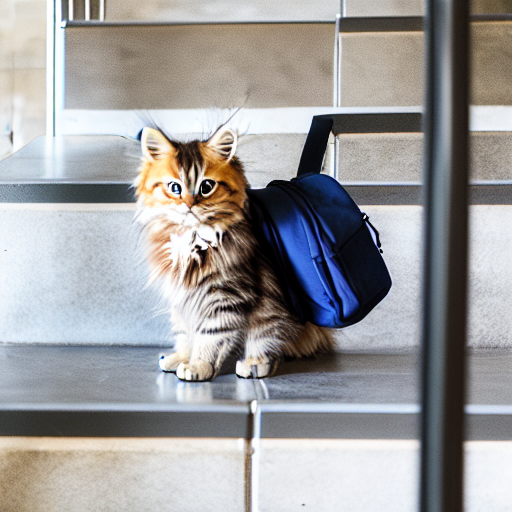

In [8]:
im